<a href="https://colab.research.google.com/github/vaishnavieduvarikuti-cpu/Brain-Tumor-ViT-Comparison/blob/main/brain%20tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import files
files.upload() # Upload your kaggle.json


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"srivaishu006","key":"bf6f15a8bdd7ee2e54639af400da6a96"}'}

In [16]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/dataset --unzip

mv: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 95% 141M/149M [00:00<00:00, 1.47GB/s]
100% 149M/149M [00:00<00:00, 1.36GB/s]


In [18]:
# ===================================================================
# FINAL CORRECTED ALL-IN-ONE CODE BLOCK
# ===================================================================

# --- CELL 1: IMPORTS ---
import os
import torch
import timm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

print("--- Step 1: Libraries Imported ---")

# --- CELL 2: CONFIGURATION ---
DATA_DIR = '/content/dataset/Training/'
TEST_DIR = '/content/dataset/Testing/'
IMAGE_SIZE = 224
BATCH_SIZE = 8 # <<< FINAL CHANGE TO FIX MEMORY ERROR
EPOCHS = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Step 2: Configuration Set (Using device: {device}, Batch Size: {BATCH_SIZE}) ---")

# --- CELL 3: DATA LOADING ---
def load_data(data_dir):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(data_dir))
    label_map = {name: i for i, name in enumerate(class_names)}
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_map[class_name])
    return pd.DataFrame({'filepath': image_paths, 'label': labels}), label_map

train_val_df, label_map = load_data(DATA_DIR)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label'])
print("--- Step 3: Data Loaded and Split ---")

# --- CELL 4: PREPROCESSING & DATASETS ---
IMAGENET_MEAN = [0.485, 0.456, 0.46]
IMAGENET_STD = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(), transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(), transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
class TumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df, self.transform = dataframe, transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path, label = self.df.iloc[idx]['filepath'], self.df.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)
train_dataset = TumorDataset(train_df, transform=train_transform)
val_dataset = TumorDataset(val_df, transform=val_test_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print("--- Step 4: DataLoaders Ready ---")

# --- CELL 5: TRAINING FUNCTION ---
def train_model(model, model_name, train_loader, val_loader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    best_val_accuracy = 0.0
    for epoch in range(epochs):
        model.train()
        print(f"\nEpoch {epoch+1}/{epochs}")
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        model.eval()
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
        val_accuracy = correct_val / len(val_loader.dataset)
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'/content/{model_name}_best.pth')
            print(f"----> New best model saved")
    print(f"\nFinished Training for {model_name}!")
    return best_val_accuracy
print("--- Step 5: Training Function Defined ---")

# --- FINAL STEP: TRAIN THE TINY MAXVIT MODEL ---
print("\n--- Starting Final Step: Training the Tiny MaxViT Model ---")
maxvit_model_name = 'maxvit_tiny_tf_224'
maxvit_model = timm.create_model(maxvit_model_name, pretrained=True, num_classes=len(label_map))
maxvit_model.to(device)
maxvit_accuracy = train_model(maxvit_model, maxvit_model_name, train_loader, val_loader, EPOCHS, 1e-5)
print(f"\nBest Validation Accuracy for Tiny MaxViT: {maxvit_accuracy:.4f}")

--- Step 1: Libraries Imported ---
--- Step 2: Configuration Set (Using device: cuda, Batch Size: 8) ---
--- Step 3: Data Loaded and Split ---
--- Step 4: DataLoaders Ready ---
--- Step 5: Training Function Defined ---

--- Starting Final Step: Training the Tiny MaxViT Model ---

Epoch 1/20


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.01it/s]


Validation Accuracy: 0.8880
----> New best model saved

Epoch 2/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.04it/s]


Validation Accuracy: 0.9501
----> New best model saved

Epoch 3/20


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.26it/s]


Validation Accuracy: 0.9571
----> New best model saved

Epoch 4/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.04it/s]


Validation Accuracy: 0.9738
----> New best model saved

Epoch 5/20


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.22it/s]


Validation Accuracy: 0.9729

Epoch 6/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.14it/s]


Validation Accuracy: 0.9720

Epoch 7/20


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.29it/s]


Validation Accuracy: 0.9834
----> New best model saved

Epoch 8/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.04it/s]


Validation Accuracy: 0.9860
----> New best model saved

Epoch 9/20


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.21it/s]


Validation Accuracy: 0.9808

Epoch 10/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.21it/s]


Validation Accuracy: 0.9851

Epoch 11/20


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.19it/s]


Validation Accuracy: 0.9869
----> New best model saved

Epoch 12/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.00it/s]


Validation Accuracy: 0.9851

Epoch 13/20


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.29it/s]


Validation Accuracy: 0.9878
----> New best model saved

Epoch 14/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.04it/s]


Validation Accuracy: 0.9834

Epoch 15/20


Validation: 100%|██████████| 143/143 [00:08<00:00, 15.94it/s]


Validation Accuracy: 0.9808

Epoch 16/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.89it/s]


Validation Accuracy: 0.9878

Epoch 17/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.71it/s]


Validation Accuracy: 0.9860

Epoch 18/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.13it/s]


Validation Accuracy: 0.9834

Epoch 19/20


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.08it/s]


Validation Accuracy: 0.9878

Epoch 20/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.06it/s]

Validation Accuracy: 0.9843

Finished Training for maxvit_tiny_tf_224!

Best Validation Accuracy for Tiny MaxViT: 0.9878


In [19]:
# --- FINAL STEP: TRAIN THE TINY SWIN TRANSFORMER ---
print("\n--- Starting Final Step: Training the Tiny Swin Transformer ---")
# NOTE: We are using the 'tiny' Swin model for a fair comparison and to avoid memory errors
swin_model_name = 'swin_tiny_patch4_window7_224'

swin_model = timm.create_model(swin_model_name, pretrained=True, num_classes=len(label_map))
swin_model.to(device)

swin_accuracy = train_model(
    model=swin_model,
    model_name=swin_model_name,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    learning_rate=1e-5
)

print(f"\nBest Validation Accuracy for Tiny Swin Transformer: {swin_accuracy:.4f}")


--- Starting Final Step: Training the Tiny Swin Transformer ---


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


Epoch 1/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 23.82it/s]


Validation Accuracy: 0.9475
----> New best model saved

Epoch 2/20


Validation: 100%|██████████| 143/143 [00:07<00:00, 20.18it/s]


Validation Accuracy: 0.9773
----> New best model saved

Epoch 3/20


Validation: 100%|██████████| 143/143 [00:05<00:00, 23.86it/s]


Validation Accuracy: 0.9764

Epoch 4/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 21.00it/s]


Validation Accuracy: 0.9746

Epoch 5/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 21.57it/s]


Validation Accuracy: 0.9843
----> New best model saved

Epoch 6/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 22.71it/s]


Validation Accuracy: 0.9816

Epoch 7/20


Validation: 100%|██████████| 143/143 [00:07<00:00, 20.36it/s]


Validation Accuracy: 0.9816

Epoch 8/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 23.64it/s]


Validation Accuracy: 0.9755

Epoch 9/20


Validation: 100%|██████████| 143/143 [00:07<00:00, 20.21it/s]


Validation Accuracy: 0.9930
----> New best model saved

Epoch 10/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 23.53it/s]


Validation Accuracy: 0.9913

Epoch 11/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 20.73it/s]


Validation Accuracy: 0.9851

Epoch 12/20


Validation: 100%|██████████| 143/143 [00:05<00:00, 23.90it/s]


Validation Accuracy: 0.9843

Epoch 13/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 21.90it/s]


Validation Accuracy: 0.9878

Epoch 14/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 22.00it/s]


Validation Accuracy: 0.9843

Epoch 15/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 21.24it/s]


Validation Accuracy: 0.9930

Epoch 16/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 22.68it/s]


Validation Accuracy: 0.9869

Epoch 17/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 21.30it/s]


Validation Accuracy: 0.9895

Epoch 18/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 22.55it/s]


Validation Accuracy: 0.9904

Epoch 19/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 20.72it/s]


Validation Accuracy: 0.9878

Epoch 20/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 22.96it/s]

Validation Accuracy: 0.9711

Finished Training for swin_tiny_patch4_window7_224!

Best Validation Accuracy for Tiny Swin Transformer: 0.9930


In [20]:
from google.colab import files
print("Please upload your kaggle.json API token.")
files.upload()

Please upload your kaggle.json API token.


Saving kaggle (1).json to kaggle (1) (1).json


{'kaggle (1) (1).json': b'{"username":"srivaishu006","key":"bf6f15a8bdd7ee2e54639af400da6a96"}'}

In [21]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/dataset --unzip

mv: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 96% 143M/149M [00:00<00:00, 1.50GB/s]
100% 149M/149M [00:00<00:00, 1.29GB/s]


In [22]:
# Imports
import os
import torch
import timm
import pandas as pd
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Configuration
DATA_DIR = '/content/dataset/Training/'
TEST_DIR = '/content/dataset/Testing/'
IMAGE_SIZE = 224
BATCH_SIZE = 8 # Use the same batch size as your final successful training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Libraries imported and configuration set. Using device: {device}")

Libraries imported and configuration set. Using device: cuda


In [23]:
# Data Loading Function
def load_data(data_dir):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(data_dir))
    label_map = {name: i for i, name in enumerate(class_names)}
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_map[class_name])
    return pd.DataFrame({'filepath': image_paths, 'label': labels}), label_map

# Load dataframes
train_val_df, label_map = load_data(DATA_DIR)
test_df, _ = load_data(TEST_DIR)

# Define Transformation
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class TumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df, self.transform = dataframe, transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path, label = self.df.iloc[idx]['filepath'], self.df.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Create the Test DataLoader
test_dataset = TumorDataset(test_df, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Test data is loaded and ready for evaluation.")

Test data is loaded and ready for evaluation.


In [24]:
def evaluate_model(model_name, test_loader, label_map):
    print(f"\n======================================================")
    print(f"   Starting Evaluation for: {model_name}")
    print(f"======================================================")

    model = timm.create_model(model_name, pretrained=False, num_classes=len(label_map))
    model_path = f'/content/{model_name}_best.pth'
    try:
        model.load_state_dict(torch.load(model_path))
    except FileNotFoundError:
        print(f"ERROR: Model file not found at {model_path}.")
        print("Please make sure you have run the training for this model OR that the saved .pth file has been uploaded to /content/.")
        return

    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_names = list(label_map.keys())
    print(f"\n--- Evaluation Report for {model_name} ---")
    print("Accuracy:", accuracy_score(all_preds, all_labels))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}'); plt.show()

--- Running Final Evaluation for Srivaishnavi's Project ---

   Starting Evaluation for: swin_tiny_patch4_window7_224


Evaluating swin_tiny_patch4_window7_224: 100%|██████████| 164/164 [00:07<00:00, 21.82it/s]



--- Evaluation Report for swin_tiny_patch4_window7_224 ---
Accuracy: 0.9900839054157132

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      0.99      0.98       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



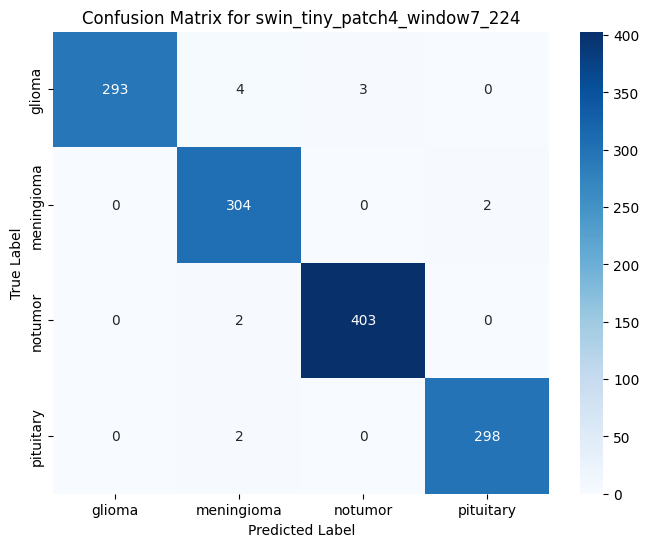


   Starting Evaluation for: maxvit_tiny_tf_224


Evaluating maxvit_tiny_tf_224: 100%|██████████| 164/164 [00:10<00:00, 15.91it/s]



--- Evaluation Report for maxvit_tiny_tf_224 ---
Accuracy: 0.8054919908466819

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.83      0.90       300
  meningioma       0.97      0.74      0.84       306
     notumor       0.63      1.00      0.78       405
   pituitary       0.96      0.58      0.73       300

    accuracy                           0.81      1311
   macro avg       0.88      0.79      0.81      1311
weighted avg       0.86      0.81      0.81      1311



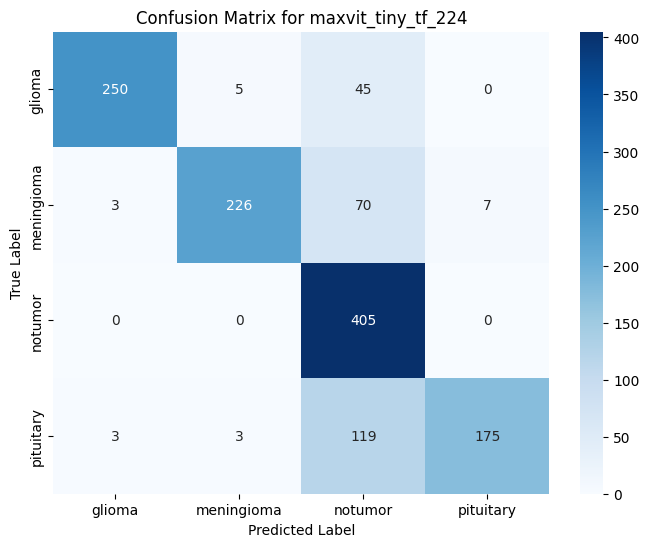

In [25]:
# --- This is the code for YOUR project (Swin + MaxViT) ---
print("--- Running Final Evaluation for Srivaishnavi's Project ---")

# Define the EXACT model names YOU trained
swin_model_name = 'swin_tiny_patch4_window7_224'
maxvit_model_name = 'maxvit_tiny_tf_224'

# Call the function for each of your models
# IMPORTANT: Make sure the files 'swin_tiny..._best.pth' and 'maxvit_tiny..._best.pth' are in your /content/ directory.
# If they are not there, you must re-run the training for them first.
evaluate_model(swin_model_name, test_loader, label_map)
evaluate_model(maxvit_model_name, test_loader, label_map)

In [26]:
from google.colab import files
files.upload() # Upload your kaggle.json

Saving kaggle (1).json to kaggle (1) (2).json


{'kaggle (1) (2).json': b'{"username":"srivaishu006","key":"bf6f15a8bdd7ee2e54639af400da6a96"}'}

In [27]:
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/dataset --unzip

mv: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 92% 136M/149M [00:00<00:00, 1.00GB/s]
100% 149M/149M [00:00<00:00, 1.01GB/s]


In [29]:
import os
import torch
import timm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Add this line for confirmation
print(f"Libraries imported successfully. Using device: {device}")

Libraries imported successfully. Using device: cuda


In [32]:
# ===================================================================
# ALL-IN-ONE CODE BLOCK FOR EXPERIMENT 1
# ===================================================================

# --- STEP 1: IMPORTS ---
import os
import torch
import timm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
print("--- Step 1: Libraries Imported ---")

# --- STEP 2: CONFIGURATION ---
DATA_DIR = '/content/dataset/Training/'
IMAGE_SIZE = 224
BATCH_SIZE = 8      # Using the safe batch size
EPOCHS = 35         # <<< EXPERIMENT 1: Training for 35 epochs
LEARNING_RATE = 1e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Step 2: Configuration Set (Device: {device}, Epochs: {EPOCHS}) ---")

# --- STEP 3: DATA LOADING ---
def load_data(data_dir):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(data_dir))
    label_map = {name: i for i, name in enumerate(class_names)}
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_map[class_name])
    return pd.DataFrame({'filepath': image_paths, 'label': labels}), label_map

train_val_df, label_map = load_data(DATA_DIR)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label'])
print("--- Step 3: Data Loaded and Split ---")
print(f"Label map: {label_map}")
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# --- STEP 4: PREPROCESSING & DATASETS ---
IMAGENET_MEAN, IMAGENET_STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(), transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(), transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
class TumorDataset(Dataset):
    def __init__(self, df, transform=None): self.df, self.transform = df, transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img_path, label = self.df.iloc[idx]['filepath'], self.df.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)
train_dataset, val_dataset = TumorDataset(train_df, transform=train_transform), TumorDataset(val_df, transform=val_test_transform)
train_loader, val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2), DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print("--- Step 4: DataLoaders Ready ---")

# --- STEP 5: TRAINING FUNCTION ---
def train_model(model, model_name, train_loader, val_loader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    best_val_accuracy = 0.0
    for epoch in range(epochs):
        model.train()
        print(f"\nEpoch {epoch+1}/{epochs}")
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        model.eval()
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
        val_accuracy = correct_val / len(val_loader.dataset)
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'/content/{model_name}_best.pth')
            print(f"----> New best model saved")
    print(f"\nFinished Training for {model_name}!")
    return best_val_accuracy
print("--- Step 5: Training Function Defined ---")

# --- FINAL STEP: TRAIN THE TINY MAXVIT MODEL ---
print("\n--- Starting Final Step: Training the Tiny MaxViT Model ---")
maxvit_model_name = 'maxvit_tiny_tf_224'
maxvit_model = timm.create_model(maxvit_model_name, pretrained=True, num_classes=len(label_map))
maxvit_model.to(device)
maxvit_accuracy = train_model(maxvit_model, maxvit_model_name, train_loader, val_loader, EPOCHS, LEARNING_RATE)
print(f"\nBest Validation Accuracy for Tiny MaxViT (Experiment 1): {maxvit_accuracy:.4f}")

--- Step 1: Libraries Imported ---
--- Step 2: Configuration Set (Device: cuda, Epochs: 35) ---
--- Step 3: Data Loaded and Split ---
Label map: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Training samples: 4569, Validation samples: 1143
--- Step 4: DataLoaders Ready ---
--- Step 5: Training Function Defined ---

--- Starting Final Step: Training the Tiny MaxViT Model ---

Epoch 1/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.78it/s]


Validation Accuracy: 0.9108
----> New best model saved

Epoch 2/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.33it/s]


Validation Accuracy: 0.9423
----> New best model saved

Epoch 3/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.97it/s]


Validation Accuracy: 0.9501
----> New best model saved

Epoch 4/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.13it/s]


Validation Accuracy: 0.9694
----> New best model saved

Epoch 5/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.51it/s]


Validation Accuracy: 0.9729
----> New best model saved

Epoch 6/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.11it/s]


Validation Accuracy: 0.9746
----> New best model saved

Epoch 7/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.60it/s]


Validation Accuracy: 0.9773
----> New best model saved

Epoch 8/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.05it/s]


Validation Accuracy: 0.9781
----> New best model saved

Epoch 9/35


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.18it/s]


Validation Accuracy: 0.9816
----> New best model saved

Epoch 10/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.81it/s]


Validation Accuracy: 0.9799

Epoch 11/35


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.27it/s]


Validation Accuracy: 0.9825
----> New best model saved

Epoch 12/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.11it/s]


Validation Accuracy: 0.9764

Epoch 13/35


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.31it/s]


Validation Accuracy: 0.9843
----> New best model saved

Epoch 14/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.93it/s]


Validation Accuracy: 0.9851
----> New best model saved

Epoch 15/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.79it/s]


Validation Accuracy: 0.9834

Epoch 16/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.99it/s]


Validation Accuracy: 0.9825

Epoch 17/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.28it/s]


Validation Accuracy: 0.9860
----> New best model saved

Epoch 18/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.98it/s]


Validation Accuracy: 0.9869
----> New best model saved

Epoch 19/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.00it/s]


Validation Accuracy: 0.9878
----> New best model saved

Epoch 20/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.98it/s]


Validation Accuracy: 0.9843

Epoch 21/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.12it/s]


Validation Accuracy: 0.9878

Epoch 22/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.34it/s]


Validation Accuracy: 0.9843

Epoch 23/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.17it/s]


Validation Accuracy: 0.9869

Epoch 24/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.43it/s]


Validation Accuracy: 0.9860

Epoch 25/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.80it/s]


Validation Accuracy: 0.9869

Epoch 26/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.03it/s]


Validation Accuracy: 0.9860

Epoch 27/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.80it/s]


Validation Accuracy: 0.9825

Epoch 28/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.52it/s]


Validation Accuracy: 0.9860

Epoch 29/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.07it/s]


Validation Accuracy: 0.9799

Epoch 30/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.61it/s]


Validation Accuracy: 0.9860

Epoch 31/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.98it/s]


Validation Accuracy: 0.9860

Epoch 32/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.57it/s]


Validation Accuracy: 0.9843

Epoch 33/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.08it/s]


Validation Accuracy: 0.9834

Epoch 34/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.65it/s]


Validation Accuracy: 0.9851

Epoch 35/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.91it/s]


Validation Accuracy: 0.9904
----> New best model saved

Finished Training for maxvit_tiny_tf_224!

Best Validation Accuracy for Tiny MaxViT (Experiment 1): 0.9904


--- Running Final Evaluation for Srivaishnavi's Project ---

   Starting Evaluation for: swin_tiny_patch4_window7_224


Evaluating swin_tiny_patch4_window7_224: 100%|██████████| 164/164 [00:07<00:00, 21.57it/s]



--- Evaluation Report for swin_tiny_patch4_window7_224 ---
Accuracy: 0.9900839054157132

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      0.99      0.98       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



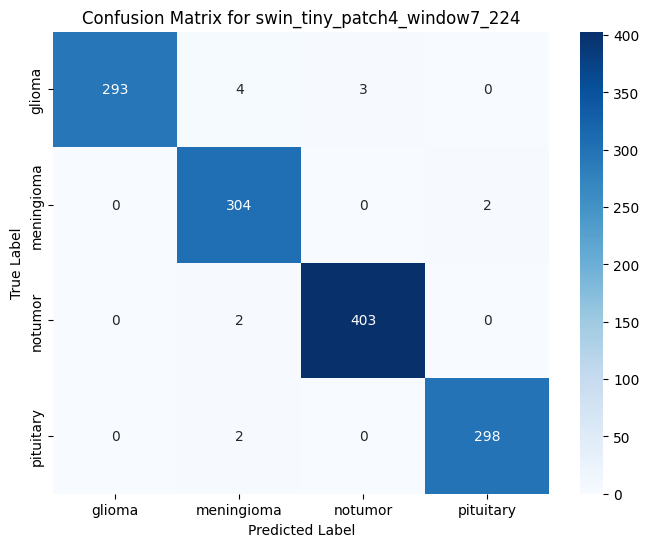


   Starting Evaluation for: maxvit_tiny_tf_224


Evaluating maxvit_tiny_tf_224: 100%|██████████| 164/164 [00:10<00:00, 14.97it/s]



--- Evaluation Report for maxvit_tiny_tf_224 ---
Accuracy: 0.9916094584286804

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



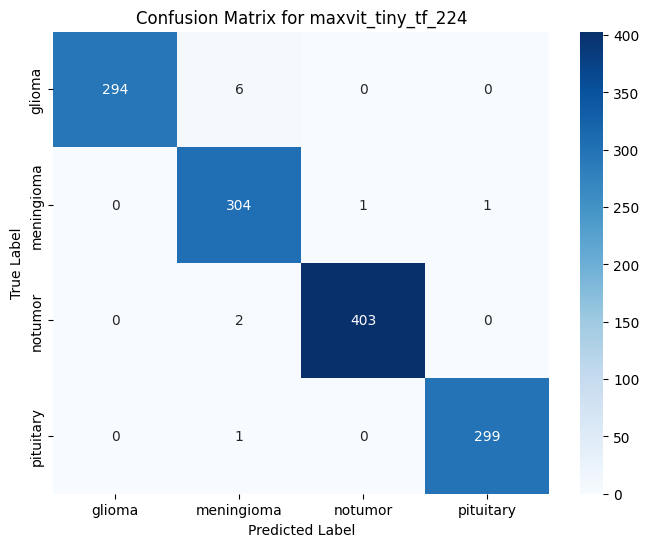

In [34]:
# --- This is the code for YOUR project (Swin + MaxViT) ---
print("--- Running Final Evaluation for Srivaishnavi's Project ---")

# Define the EXACT model names YOU trained
swin_model_name = 'swin_tiny_patch4_window7_224'
maxvit_model_name = 'maxvit_tiny_tf_224'

# Call the function for each of your models
# IMPORTANT: Make sure the files 'swin_tiny..._best.pth' and 'maxvit_tiny..._best.pth' are in your /content/ directory.
# If they are not there, you must re-run the training for them first.
evaluate_model(swin_model_name, test_loader, label_map)
evaluate_model(maxvit_model_name, test_loader, label_map)